# Imports

In [80]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Loading and cleaning data

In [99]:
# Load data
DATA_PATH = "/Users/teymour/Desktop/cmor438/data/meteorite-landings.csv"
df = pd.read_csv(DATA_PATH)

# Clean data (drop NA)
df = df.dropna()

# Data exploration

,mass,year,reclat,reclong
count,3.811600e+04,38116.000000,38116.000000,38116.000000
mean,1.560031e+04,1989.957472,-39.594193,61.308320
std,6.286735e+05,26.444565,46.177476,80.776778
min,0.000000e+00,601.000000,-87.366670,-165.433330
25%,6.630000e+00,1986.000000,-76.716670,0.000000
50%,2.909000e+01,1996.000000,-71.500000,35.666670
75%,1.874100e+02,2002.000000,0.000000,157.166670
max,6.000000e+07,2101.000000,81.166670,178.200000


fall_Found    0.972059
fall_Fell     0.027941
dtype: float64

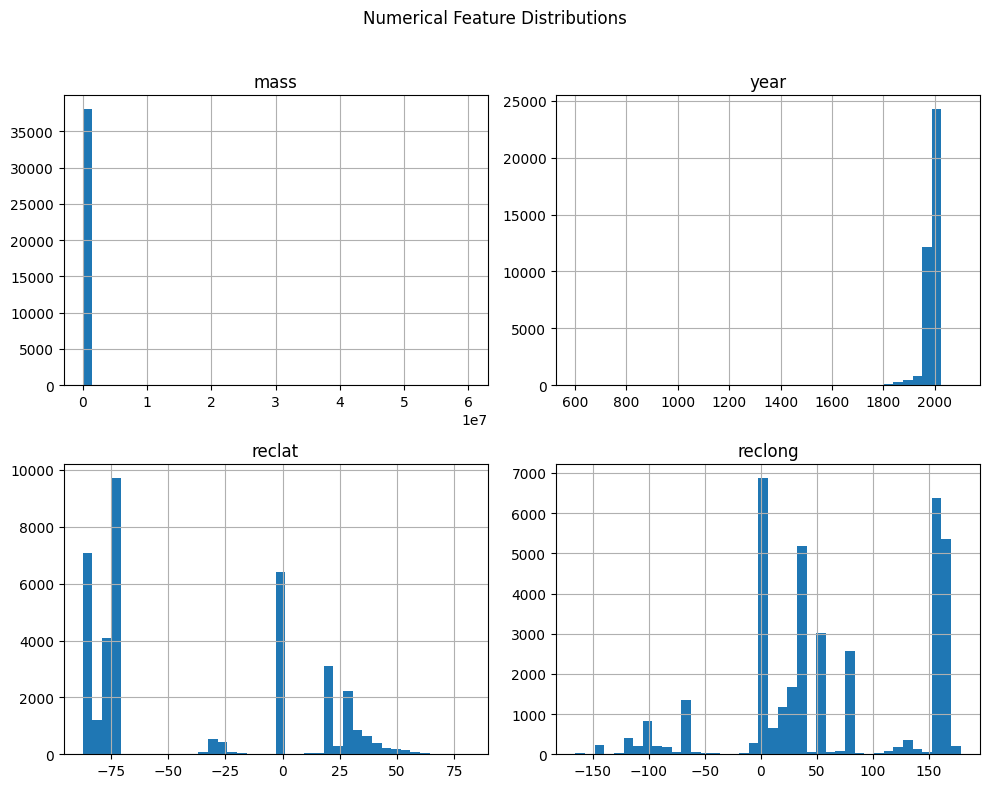

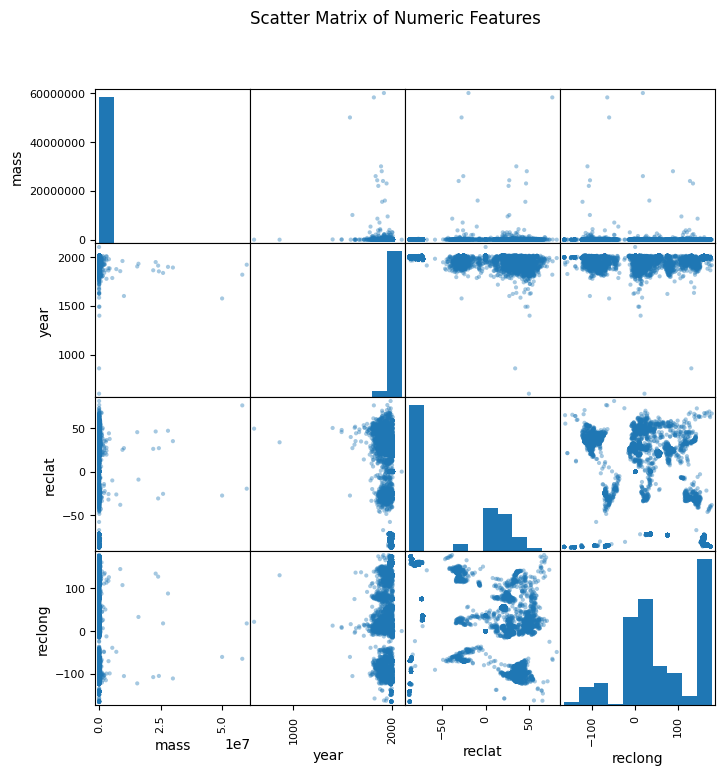

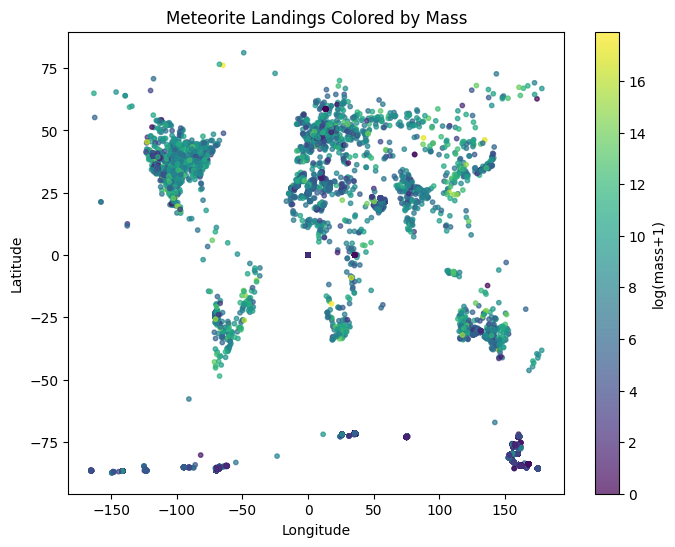

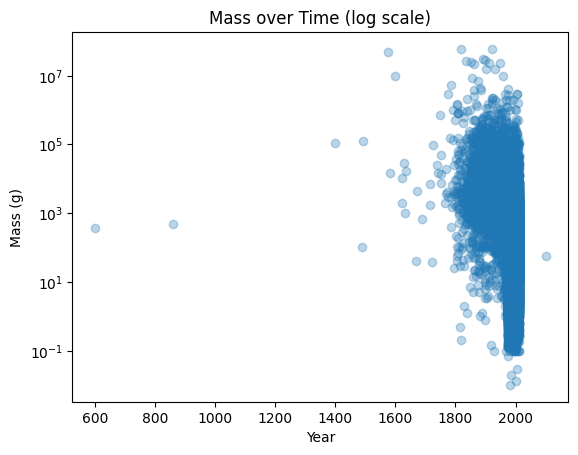

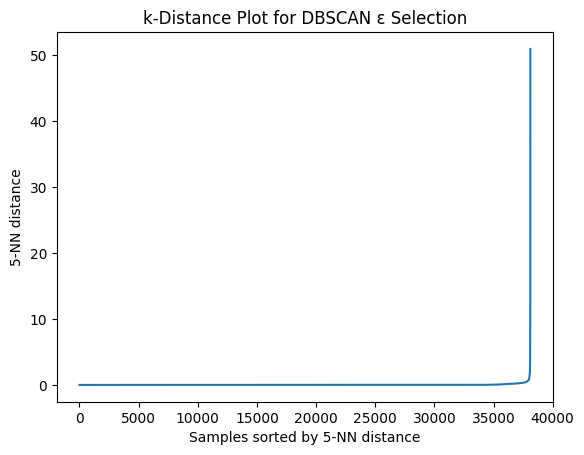

In [115]:
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

# one-hot encode 'fall'
df['fall_Found'] = (df['fall'] == 'Found').astype(int)
df['fall_Fell']  = (df['fall'] == 'Fell').astype(int)

# select features for exploration
numeric = ['mass','year','reclat','reclong']
categorical = ['fall_Found','fall_Fell']

# descriptive statistics
display(df[numeric].describe())
display(df[categorical].mean())  # proportion of each fall type

# histograms of numeric features
df[numeric].hist(bins=40, figsize=(10,8))
plt.suptitle('Numerical Feature Distributions')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# scatter matrix of numeric features
scatter_matrix(df[numeric], diagonal='hist', alpha=0.4, figsize=(8,8))
plt.suptitle('Scatter Matrix of Numeric Features')
plt.show()

# geospatial plot colored by mass (log scale)
plt.figure(figsize=(8,6))
sc = plt.scatter(
    df['reclong'], df['reclat'],
    c=np.log1p(df['mass']), cmap='viridis', s=10, alpha=0.7
)
plt.colorbar(sc, label='log(mass+1)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Meteorite Landings Colored by Mass')
plt.show()

# scatter: mass vs year
plt.figure()
plt.scatter(df['year'], df['mass'], alpha=0.3)
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Mass (g)')
plt.title('Mass over Time (log scale)')
plt.show()

# prepare data for DBSCAN epsilon selection
X = pd.concat([df[numeric], df[categorical]], axis=1).values
X_scaled = StandardScaler().fit_transform(X)

# k-distance plot (5th nearest neighbor)
nbrs = NearestNeighbors(n_neighbors=5).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
k_dist = np.sort(distances[:, 4])
plt.figure()
plt.plot(k_dist)
plt.xlabel('Samples sorted by 5-NN distance')
plt.ylabel('5-NN distance')
plt.title('k-Distance Plot for DBSCAN ε Selection')
plt.show()


# DBSCAN clustering model

cluster
-1       33
 0     1059
 1    37024
Name: count, dtype: int64

,mass,year,reclat,reclong,fall_Found,fall_Fell
cluster_0,22058.028093,1916.186025,30.033337,20.024684,0.0,1.0
cluster_1,3406.874181,1992.274146,-41.636877,62.544133,1.0,0.0


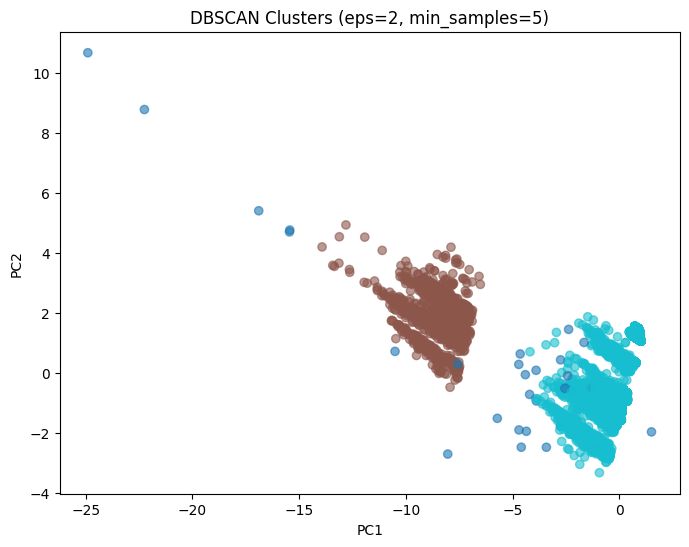

In [120]:
features = numeric + categorical  # ['mass','year','reclat','reclong','fall_Found','fall_Fell']

# extract and scale feature matrix
X = df[features].values
X_scaled = StandardScaler().fit_transform(X)

# fit DBSCAN using ε chosen from k-distance plot (e.g., eps=2) and min_samples=5
db = DBSCAN(eps=2, min_samples=5)
labels = db.fit_predict(X_scaled)
df['cluster'] = labels

# display cluster counts (-1 = noise)
display(df['cluster'].value_counts().sort_index())

# compute and display centroids for each non-noise cluster
centroids = []
cluster_ids = [c for c in np.unique(labels) if c != -1]
for c in cluster_ids:
    centroid = df.loc[df['cluster'] == c, features].mean().values
    centroids.append(centroid)
centroids_df = pd.DataFrame(centroids, columns=features, index=[f'cluster_{c}' for c in cluster_ids])
display(centroids_df)

# visualize clusters in 2D via PCA on scaled features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clusters (eps=2, min_samples=5)')
plt.show()


# Discussion of results

DBSCAN with ε=2 and min_samples=5 identified two major clusters plus 33 noise points. Cluster 1 centers on small, recent finds (mean mass≈3407 g, year≈1992) scattered around mid‐latitude longitudes (≈–42°, 62°), with all “Fall” entries. Cluster 0 (n=1 059) captures much larger, older meteorites (mean mass≈22058 g, year≈1916) around (≈30°, 20°) that fell rather than were found. The 33 noise points are extreme outliers (very late/early years or huge mass) that neither density threshold groups. Unlike K-Means, DBSCAN naturally isolates these sparse outliers and reveals two distinct density-based landing zones: a broad background of smaller modern finds and a tighter cluster of massive historical falls. 